In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/int3405-sentiment-analysis-problem/test.csv
/kaggle/input/int3405-sentiment-analysis-problem/full_train.csv


**Download file .csv**

In [2]:
!wget https://github.com/cuongprotector/Food-Comments-Sentiment-Analysis/raw/main/food_train.csv

--2022-12-09 05:17:25--  https://github.com/cuongprotector/Food-Comments-Sentiment-Analysis/raw/main/food_train.csv
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/cuongprotector/Food-Comments-Sentiment-Analysis/main/food_train.csv [following]
--2022-12-09 05:17:26--  https://raw.githubusercontent.com/cuongprotector/Food-Comments-Sentiment-Analysis/main/food_train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22308229 (21M) [text/plain]
Saving to: ‘food_train.csv’

food_train.csv      100%[===================>]  21.27M   133MB/s    in 0.2s    

2022-12-09 05:17:26 (133 MB/s) - ‘food_train.

In [3]:
!pip install pyvi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 32.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 kB 46.5 MB/s eta 0:00:00


**Import Library**

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import nltk
from nltk.stem import WordNetLemmatizer
from pyvi import ViTokenizer, ViPosTagger

from sklearn.model_selection import train_test_split

from tensorflow import keras
from keras import layers
from keras.utils.vis_utils import plot_model

from wordcloud import WordCloud

import warnings
warnings.filterwarnings("ignore")


%matplotlib inline

**Read .csv**

In [5]:
food_train_df = pd.read_csv('/kaggle/working/food_train.csv',encoding='UTF8')

In [6]:
food_train_df.head(10)

,Unnamed: 0,Comment,Rating
0,0,"Xôi dẻo, đồ ăn đậm vị. Hộp xôi được lót lá trô...",1
1,1,Gọi ship 1 xuất cari gà bánh naan và 3 miếng g...,0
2,2,"Thời tiết lạnh như này, cả nhà rủ nhau đến leg...",1
3,3,Em có đọc review thấy mng bảo trà sữa nướng đề...,0
4,4,"Đồ ăn rất ngon, nhà hàng cũng rất đẹp, tất cả ...",1
5,5,"Đồ ăn ngon, đặt qua now shop để k cẩn thận bị ...",0
6,6,Nhà hàng yêu thích của mình đây nè! Đến đây mì...,1
7,7,"🔸Vị trí: mặt đường Trung Yên rất dễ tìm, một d...",1
8,8,"Mình đã ăn tại đây và rất ngon,\nChuẩn vị phố ...",1
9,9,"Thịt mềm, sốt ngon, dưa góp ăn cùng đỡ ngán\nM...",1


**EDA**

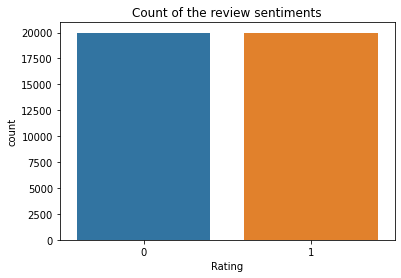

0    19988
1    19981
Name: Rating, dtype: int64


In [7]:
sns.countplot(food_train_df['Rating'])
plt.title('Count of the review sentiments')
plt.show()
print(food_train_df['Rating'].value_counts())

The distribution is unbiased.

In [8]:
# wordcloud of reviews with sentiment -> Positive (label 1)

def get_visuals(df,column_name,value):
    s=','
    for element in df[df[column_name]==value]['Comment']:
        s+=str(element)
    
    wordcloud=WordCloud(background_color='white',
                    random_state=101,
                   width=800,
                   height=800).generate(s)
    
    plt.figure(figsize=(12,8))
    plt.axis('off')
    plt.grid(False)
    plt.imshow(wordcloud)
    plt.show()

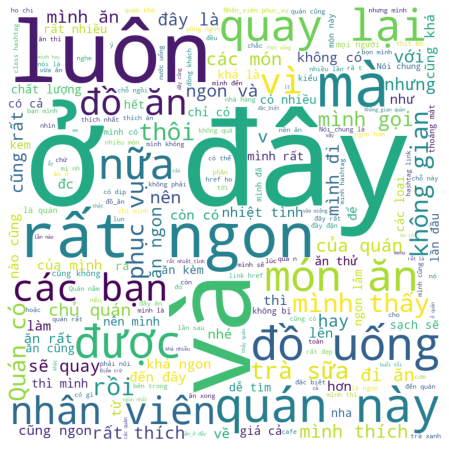

In [9]:
get_visuals(food_train_df,'Rating',1)

**Text processing**

In [12]:
def prepare_data_not_stopw(df,column_name):
    data=df[column_name]
    
    lemmatizer=WordNetLemmatizer()
    corpus=data.tolist()
    final_corpus=[]
    
    for i in range(len(corpus)):
        word=ViTokenizer.tokenize(corpus[i].lower())
        word= ViPosTagger.postagging(word)[0]
        word=[
            lemmatizer.lemmatize(y) for y in word ]
        j=" ".join(word)
        j=re.sub(r'[^\w\s]', " ", j)
        j=re.sub("(^|\W)\d+"," ",j)
        
        final_corpus.append(j)
    
    return final_corpus

In [13]:
nltk.download('omw-1.4')
import re

[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


In [14]:
final_corpus=prepare_data_not_stopw(food_train_df,'Comment')

label_=food_train_df['Rating']
train_df={
    'label':label_,
    'content':final_corpus,
}

train_df=pd.DataFrame(train_df)
train_df.head()

,label,content
0,1,xôi dẻo đồ ăn_đậm vị hộp xôi được lót lá t...
1,0,gọi ship xuất cari gà bánh naan và miếng gà ...
2,1,thời_tiết lạnh như này cả nhà rủ nhau đến le...
3,0,em có đọc review thấy mng bảo trà sữa nướng đề...
4,1,đồ ăn rất ngon nhà_hàng cũng rất đẹp tất_c...


**Deep Learning Model
LSTM Model**

In [15]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = keras.preprocessing.text.Tokenizer(num_words=MAX_NB_WORDS,filters='!"#$%&*+,./=>?[\\]`{|}\t\n',)
tokenizer.fit_on_texts(train_df['content'].values)
word_index = tokenizer.word_index  
print('Found %s unique tokens.' % len(word_index))

Found 40022 unique tokens.


In [16]:
X = tokenizer.texts_to_sequences(train_df['content'].values)
X = keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (39969, 250)


In [17]:
Y = pd.get_dummies(train_df['label']).values
print('Shape of label tensor:', Y.shape)
print(Y[:10,:])

Shape of label tensor: (39969, 2)
[[0 1]
 [1 0]
 [0 1]
 [1 0]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [0 1]]


In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 101)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(31975, 250) (31975, 2)
(7994, 250) (7994, 2)


**Model Architecture**

In [19]:
model = keras.Sequential()
model.add(keras.layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(keras.layers.SpatialDropout1D(0.2))
model.add(keras.layers.LSTM(100, dropout=0.3, recurrent_dropout=0.2))
model.add(keras.layers.Dense(2, activation='softmax'))

model.compile(loss='CategoricalCrossentropy', optimizer='adam', metrics=[keras.metrics.AUC()])

2022-12-09 05:44:44.525009: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-09 05:44:44.526079: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-09 05:44:44.721163: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-09 05:44:44.722937: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-09 05:44:44.724454: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 250, 100)          5000000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 250, 100)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 2)                 202       
Total params: 5,080,602
Trainable params: 5,080,602
Non-trainable params: 0
_________________________________________________________________


In [21]:
# This callback will stop the training when there is no improvement in
# the loss for three consecutive epochs.
epochs = 4
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs,steps_per_epoch=100, batch_size=batch_size,validation_split=0.2)

2022-12-09 05:44:55.394940: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/4
100/100 [==============================] - 132s 1s/step - loss: 0.5327 - auc: 0.8117 - val_loss: 0.3623 - val_auc: 0.9197
Epoch 2/4
100/100 [==============================] - 128s 1s/step - loss: 0.3538 - auc: 0.9229 - val_loss: 0.3312 - val_auc: 0.9339
Epoch 3/4
100/100 [==============================] - 129s 1s/step - loss: 0.3508 - auc: 0.9243 - val_loss: 0.3209 - val_auc: 0.9375
Epoch 4/4
100/100 [==============================] - 128s 1s/step - loss: 0.3514 - auc: 0.9240 - val_loss: 0.3438 - val_auc: 0.9276


**Model Evaluation**

In [22]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

250/250 [==============================] - 17s 68ms/step - loss: 0.3338 - auc: 0.9314
Test set
  Loss: 0.334
  Accuracy: 0.931


In [23]:
model.save("LSTM.h5")

In [27]:
def get_plot(trained_model,no_epochs):
    accuracy=trained_model.history['auc']
    loss=trained_model.history['loss']
    val_accuracy=trained_model.history['val_auc']
    val_loss=trained_model.history['val_loss']
    epochs=[i for i in range(1,no_epochs+1)]

    plt.figure(figsize=(12,8))
    plt.plot(epochs,accuracy,'r',label='Training')
    plt.plot(epochs,val_accuracy,'--',label='Validation')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy',fontsize=15)
    plt.grid()
    plt.show()

    plt.figure(figsize=(12,8))
    plt.plot(epochs,loss,'r',label='Training')
    plt.plot(epochs,val_loss,'--',label='Validation')
    plt.legend()
    plt.title('Loss',fontsize=15)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid()
    plt.show()

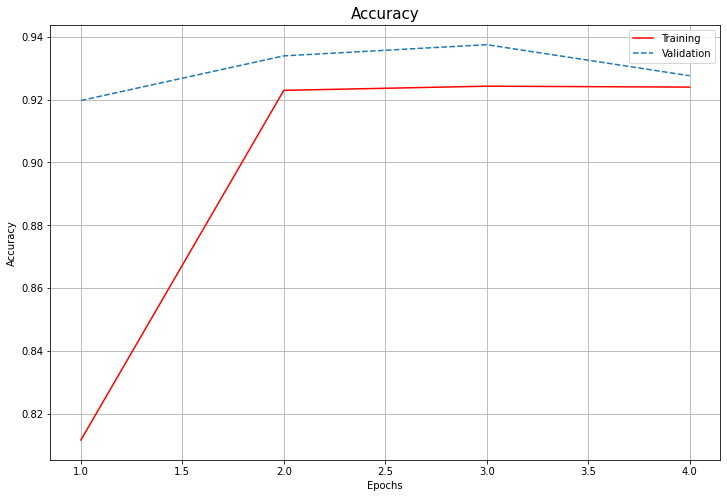

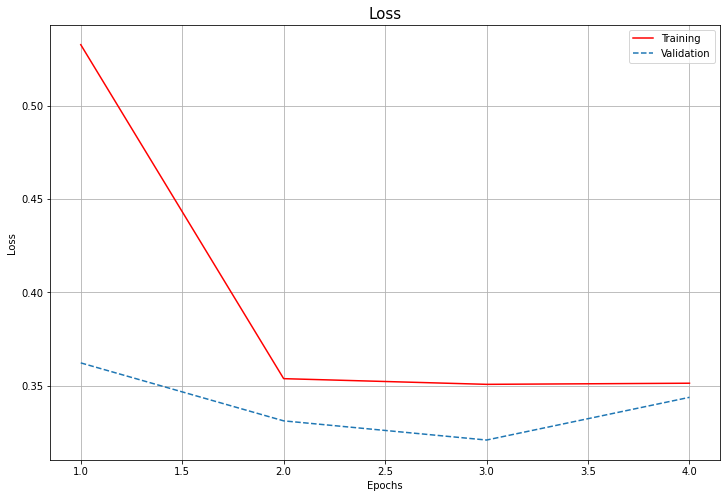

In [28]:
get_plot(history,4)

**CONCLUSION**

**LSTM Model: 94.19% accuracy**

**METRICS USED
AUC-ROC Score**

In [29]:
test = pd.read_csv('/kaggle/input/int3405-sentiment-analysis-problem/test.csv')
test["Comment"] = test["Comment"].astype('str')
test

,Unnamed: 0,RevId,UserId,Comment,image_urls
0,0,781115,1326532,Trà táo 35k\nCookie socola 38k \nNước ở đây bì...,['https://images.foody.vn/res/g8/73091/s800/fo...
1,1,1219481,422306,Hôm rồi trung tâm mình tổ chức noel party ở đâ...,['https://images.foody.vn/res/g1/33/s800/foody...
2,2,1703765,9779143,Thịt gà của quán là nhất đấy. Đi ăn gọi liền 4...,['https://images.foody.vn/res/g66/659655/s800/...
3,3,4870346,12924388,Hai đứa ăn xong đau bụng cả ngày\nChân gà ok n...,['https://images.foody.vn/res/g78/772244/s800/...
4,4,2638711,1134279,Mình vừa thử trưa nay. Điểm cộng đầu tiên là b...,['https://images.foody.vn/res/g74/737874/s800/...
...,...,...,...,...,...
5098,5098,1025826,132889,"Bún riêu ở đây ngon mà, lúc nào cũng đông, thế...",['https://images.foody.vn/res/g10/92649/s800/f...
5099,5099,1278470,1691594,Quán ngồi thoải mái và cưc thích ❤ menu đa dạn...,['https://images.foody.vn/res/g25/247296/s800/...
5100,5100,2565212,9989615,"Quá thất vọng, chất lượng sản phẩm ngày càng đ...",['https://images.foody.vn/res/g89/888154/s800/...
5101,5101,3766155,17686862,"Giao hàng nhanh, miếng băm chả đều ngon ko bị...",['https://images.foody.vn/res/g13/128194/s800/...


In [30]:
final_corpus=prepare_data_not_stopw(test,'Comment')
test_df={
    'content':final_corpus,
}

test_df=pd.DataFrame(test_df)
test_df.head()

,content
0,trà táo k \n cookie socola k \n nước ở đây bìn...
1,hôm rồi trung_tâm mình tổ_chức noel party ở đâ...
2,thịt gà của quán là nhất đấy đi ăn gọi liền ...
3,hai đứa ăn xong đau bụng cả ngày \n chân gà ok...
4,mình vừa thử trưa nay điểm cộng đầu_tiên là ...


In [33]:
X_test = tokenizer.texts_to_sequences(test_df['content'].values)
X_test = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X_test.shape)

Shape of data tensor: (5103, 250)


In [34]:
LSTM_model = keras.models.load_model('/kaggle/working/LSTM.h5')
LSTM_predicted =LSTM_model.predict(X_test) 
LSTM_predicted.shape

(5103, 2)

In [36]:
Rated = LSTM_predicted[:,1]
Rated.shape

(5103,)

In [37]:
Rating = []
for i in Rated:
    Rating.append(i)

In [39]:
my_submission = pd.DataFrame({'RevId': test.RevId, 'Rating': Rating})
# you could use any filename. We choose submission here
my_submission.to_csv('submission2.csv', index=False)

In [40]:
my_submission.head()

,RevId,Rating
0,781115,0.022128
1,1219481,0.023514
2,1703765,0.862783
3,4870346,0.212757
4,2638711,0.866011
